In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import mmt_simulator as mmt

import knn_mi_comp as mi 
import my_causation_entropy_builder as my_ceb
import wwt_tools as wwt

import pickle

%matplotlib inline 

Pi = np.pi

In [2]:
def scale_sep_correlation_and_et_graph(tseries, dts, ep_val, avgscl, dep_fac, lends, rends):
    
    multiscale_sep, tskip = wwt.scale_sep_and_downsampling(tseries, dts, ep_val, avgscl, inertialleft, inertialright, lends, rends)
    mscl_sep_dep = multiscale_sep[:, ::dep_fac]
    mscl_sep_dep = wwt.zero_average_scale(mscl_sep_dep)
    dts_fine = dts * dep_fac
    return mscl_sep_dep, dts_fine

In [3]:
def scale_sep_plot(multiscale_sep, dts_local, init, tag):
    taxis = init + dts_local*np.arange(multiscale_sep.shape[1])
    plt.figure(figsize=(8, 6))
    colors = ['k', 'r', 'b', 'g']
    for ll in range(multiscale_sep.shape[0]):
        title = r"$F_{" + str(ll) + "}(t)$"
        plt.plot(taxis, multiscale_sep[ll, :], c=colors[ll], ls='-', label=title)
    plt.xlabel(r"$t$")
    plt.ylabel(r"$F_{j}(t)$")
    plt.legend()
    plt.savefig(f"F_plots"+tag+".pdf", dpi=150, bbox_inches='tight') 


def ac_corr_sep_plot(multiscale_sep, dts_fine, tag):
    skp = 0
    taxis = dts_fine*np.arange(multiscale_sep.shape[1])
        
    nlags = int(multiscale_sep.shape[1]/2)
    plt.figure(figsize=(8, 6)) 
    acf_result = acf(multiscale_sep[0, skp:-1], nlags=nlags)
    colors=['k', 'r', 'b', 'g']
    for ll in range(len(colors)):
        title = r"$F_{" + str(ll) + "}(t)$"
        plt.plot(taxis[:nlags+1], acf(multiscale_sep[ll, skp:-1], nlags=nlags), color=colors[ll], label=title)
    pvbar = 1.96/np.sqrt(np.size(np.array(acf_result)))
    plt.plot(taxis[:nlags+1], pvbar*np.ones(len(acf_result)), color='b', ls='--')
    plt.plot(taxis[:nlags+1], -pvbar*np.ones(len(acf_result)), color='b', ls='--')

    plt.xlabel(r"$t$")
    plt.ylabel(r"$ACF(F_{j}(t))$")
    plt.legend()
    plt.savefig(f"ACF_plots"+tag+".pdf", dpi=150, bbox_inches='tight') 

In [4]:
plt.rcParams.update({ "text.usetex": True, "font.family": "serif" })
font = {'size': 16}
matplotlib.rc('font', **font)

fmt = 'pdf'
weight_str = 'max_te_lag'

In [5]:
fac = 1.
Llx = fac*np.pi
Nval = 2**(11 + int(fac)-1)

inertialleft = 50 * np.pi/Llx
inertialright = 500 * np.pi/Llx

dt = 5e-3
ep_val = .5/fac
alpha = .5
gamma = 2.

samp_rate_time = 10/ep_val**2.
samp_rate = int(samp_rate_time/dt)
print([samp_rate_time, samp_rate])

dts = samp_rate * dt
turnovers = 100.
tf = turnovers*inertialright/ep_val**2.

Dxa = np.pi/Llx * np.abs(np.concatenate((np.arange(Nval+1),np.arange(-Nval+1,0,1)),0)) # note, we never need a naked Dx
Dxalpha = Dxa**alpha   
    

print(tf)

[40.0, 8000]
199999.99999999997


In [6]:
reload = True
if reload:
  sol, sol0, tavg, tseries = pickle.load(open("wwt_run_file_very_long.pkl", "rb"))
else:
  sol, sol0, tavg, tseries = mmt.mmt_solver(Nval, Llx, tf, ep_val, dt, samp_rate, inertialright)
  pickle.dump([sol, sol0, tavg, tseries], open("wwt_run_file_very_long.pkl", "wb"))


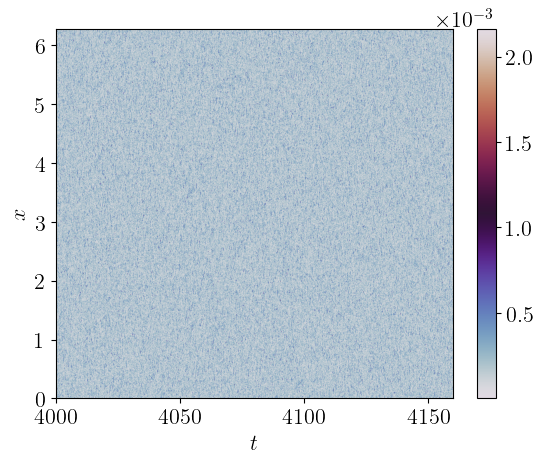

In [7]:
num_t_steps_for_plotting = 800
plt_scl_fac = 1
tvals = 2*inertialright/ep_val**2 + plt_scl_fac*40*dt*np.arange(int(num_t_steps_for_plotting/plt_scl_fac))
xvals = np.linspace(-Llx,Llx,2*Nval)
fig, ax = plt.subplots()

# Plot the data with a colormap

#plt.contourf(tvals,xvals,np.abs(np.fft.ifft(tseries[:,:num_t_steps_for_plotting:plt_scl_fac],axis=0)),levels=30)
im = ax.imshow(np.abs(np.fft.ifft(tseries[:,:num_t_steps_for_plotting:plt_scl_fac],axis=0)),cmap='twilight',origin='lower',
                   extent=[tvals[0], tvals[-1], 0., 2.*np.pi], clip_on=True,aspect='auto')
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$x$")

cbar = fig.colorbar(im)
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2e}'))
cbar.update_ticks()
plt.savefig("MMT_space_time_dynamics.pdf", dpi=150, bbox_inches='tight')  

In [8]:
inertialleft = 50
inertialright = 500
inertialk = np.arange(inertialleft, inertialright)

A = np.vstack([np.ma.log10(inertialk), np.ones(inertialk.size)]).T
m, c = np.linalg.lstsq(A, np.ma.log10(tavg[inertialleft:inertialright]))[0]
print([m, c])

[-1.0422997545520574, -0.9930766231889105]


/tmp/ipykernel_903421/1731244808.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, np.ma.log10(tavg[inertialleft:inertialright]))[0]


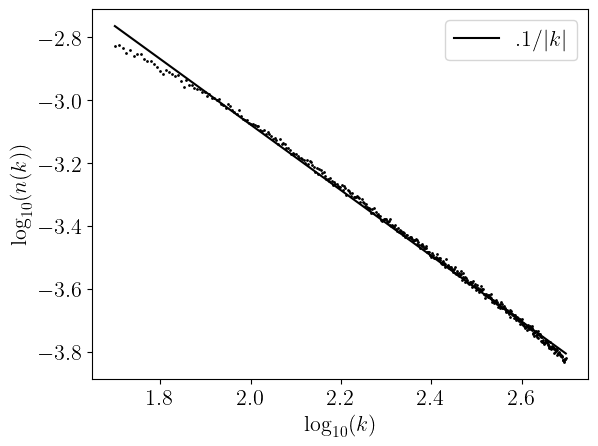

In [9]:
plt.scatter(np.ma.log10(inertialk), np.ma.log10(tavg[inertialleft:inertialright]), s=1.,color='k')
plt.plot(np.ma.log10(inertialk), np.ma.log10(10.**c * inertialk**(m)), color='k', label=r"$.1/|k|$")
plt.legend()
plt.xlabel(r"$\log_{10}(k)$")
plt.ylabel(r"$\log_{10}(n(k))$")
plt.savefig("Equilibrium_Distribution_w_Fit.pdf", dpi=150, bbox_inches='tight')  

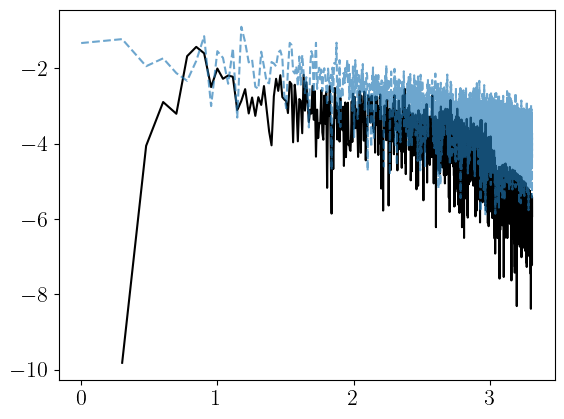

In [10]:
solclipped = np.abs(sol[:Nval])**2.
sol0clipped = np.abs(sol0[:Nval])**2.

kvals = np.arange(Nval)
#plt.plot(np.ma.log10(kvals[inertialleft:inertialright]), shift_scale_fft1[inertialleft:inertialright], color='k')#
#plt.plot(np.ma.log10(kvals[inertialleft:inertialright]), np.ma.log10(kvals**(-1.)), color='r')
#plt.plot(np.ma.log10(kvals[inertialleft:inertialright]), sol0clipped[inertialleft:inertialright], color='r', ls='--')

plt.plot(np.ma.log10(kvals), np.ma.log10(solclipped), color='k')
plt.plot(np.ma.log10(kvals), np.ma.log10(sol0clipped), ls='--', alpha=.65)


In [11]:
inertialleft = 50
inertialright = 600
taction_long = np.abs(tseries)**2.

taction_long[inertialright:-inertialright, :] = 0
taction_long[:inertialleft, :] = 0
taction_long[-inertialleft:, :] = 0
trans_action = taction_long[inertialleft:inertialright,:]
tskip_long = int(500/ep_val**2. * 1./dts)
eq_dist = np.mean(trans_action,axis=1)
print(tskip_long)

smooth_trans_action = np.zeros((trans_action.shape[0], trans_action.shape[1]-tskip_long), dtype=np.float64)
for jj in range(trans_action.shape[1]-tskip_long):
    smooth_trans_action[:, jj] = np.mean(trans_action[:,jj:jj+tskip_long],axis=1)  - eq_dist

# disjoint intervals
inertialright_clip = 500
lends = np.array([0, 
                  int(.25*(inertialright_clip-inertialleft)), 
                  int(.5*(inertialright_clip-inertialleft)), 
                  int(.75*(inertialright_clip-inertialleft))])

rends = np.array([int(.25*(inertialright_clip-inertialleft)), 
                  int(.5*(inertialright_clip-inertialleft)), 
                  int(.75*(inertialright_clip-inertialleft)), 
                  int((inertialright_clip-inertialleft))])

50


In [12]:
cut_scl_fac = 10
time_step_cut = int(tskip_long/cut_scl_fac)
trans_action_cut = smooth_trans_action[:, ::time_step_cut]
dts_cut = time_step_cut*dts

In [13]:
from scipy.stats import skew
bin_cnt = 10
histograms_raw = np.zeros((len(lends),bin_cnt,trans_action_cut.shape[1]),dtype=np.float64)

trans_mean = np.zeros((len(lends),trans_action_cut.shape[1]),dtype=np.float64)
trans_var = np.zeros((len(lends),trans_action_cut.shape[1]),dtype=np.float64)
trans_skew = np.zeros((len(lends),trans_action_cut.shape[1]),dtype=np.float64)
scaled_trans_action = np.zeros((len(lends),int(rends[0]-lends[0])+1, trans_action_cut.shape[1]),dtype=np.float64)
fixed_bins = [None]*len(lends)

for kk in range(len(lends)):
    for jj in range(int(trans_action_cut.shape[1])):
        local_cut = trans_action_cut[lends[kk]:rends[kk],jj]
        trans_mean[kk,jj] = np.mean(local_cut)
        trans_var[kk,jj] = np.sqrt(np.var(local_cut))
        za_scl_local_cut = (local_cut-trans_mean[kk,jj])/trans_var[kk,jj]
        scaled_trans_action[kk, :za_scl_local_cut.size, jj] = za_scl_local_cut

    tact_max = np.max(np.max(scaled_trans_action[kk, :, :]))
    tact_min = np.min(np.min(scaled_trans_action[kk, :, :]))
    fixed_bins[kk] = np.linspace(tact_min, tact_max, bin_cnt+1)

    for jj in range(trans_action_cut.shape[1]):
        local_cut = scaled_trans_action[kk, :, jj]

        hist, current_bins = np.histogram(local_cut, bins=fixed_bins[kk], density=True)
        trans_skew[kk,jj] = skew(local_cut)
        histograms_raw[kk, :, jj] = hist
    

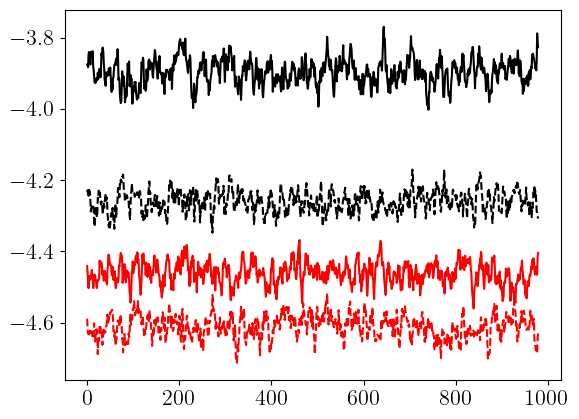

In [14]:
colors = ['k', 'k', 'r', 'r']
styles = ['-', '--', '-', '--']

for jj in range(len(lends)):
    plt.plot(np.log10(trans_var[jj, :]),c=colors[jj],ls=styles[jj])

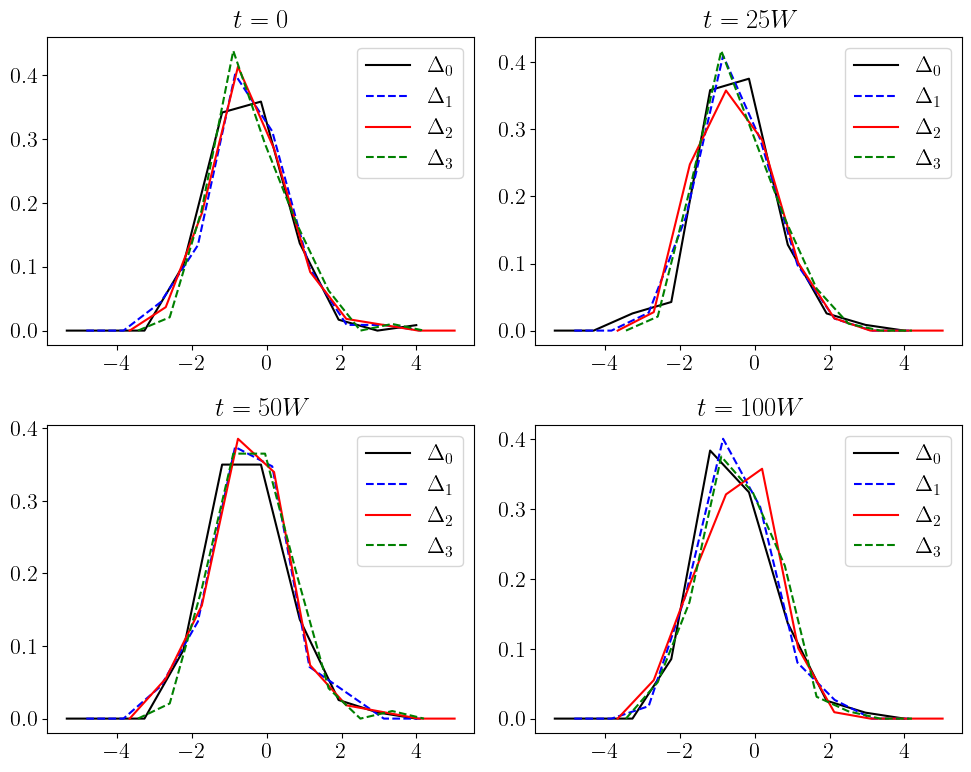

In [15]:
colors = ['k', 'b', 'r', 'g']
styles = ['-', '--', '-', '--']
labels = [r'$\Delta_{0}$', r'$\Delta_{1}$', r'$\Delta_{2}$', r'$\Delta_{3}$']
local_title = [r'$t=0$', r'$t=25W$', r'$t=50W$', r'$t=100W$']
tsteps = int(histograms_raw.shape[2]/4.)
fix, axes = plt.subplots(2,2,figsize=(10,8))
flat_axes = axes.ravel()
for kk in range(len(flat_axes)):
    for jj in range(len(lends)):
        flat_axes[kk].plot(fixed_bins[jj][:-1], histograms_raw[jj, :, int(kk*tsteps)],
                           color=colors[jj], ls=styles[jj], label=labels[jj])
    flat_axes[kk].set_title(local_title[kk])
    flat_axes[kk].legend()
plt.tight_layout()
plt.savefig("Histograms_in_Time.pdf", dpi=150, bbox_inches='tight')  

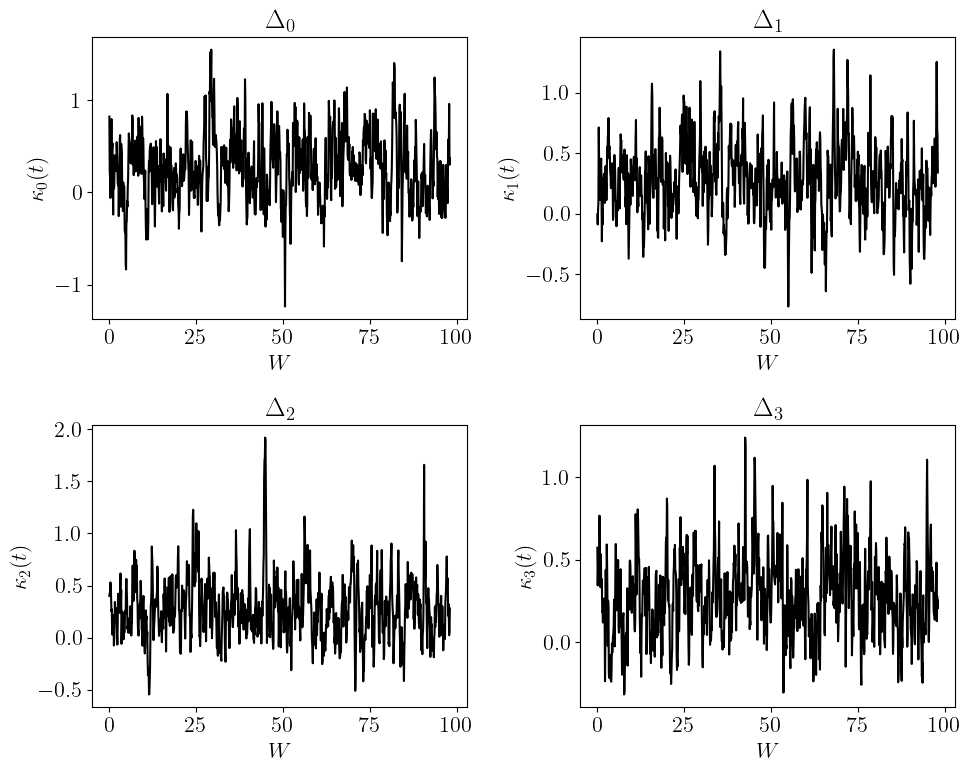

In [16]:
fig, axes = plt.subplots(2,2,figsize=(10,8))
flat_ax = axes.ravel()
for jj in range(len(flat_ax)):
    flat_ax[jj].plot(np.arange(trans_action_cut.shape[1])/cut_scl_fac, trans_skew[jj,:],color='k')
    #ax.plot(np.arange(trans_action_cut.shape[1])/cut_scl_fac, np.ones(trans_action_cut.shape[1])*mean_skw,color='r',ls='--')
    flat_ax[jj].set_ylabel(r"$\kappa_{" + str(jj) + "}(t)$")
    flat_ax[jj].set_xlabel(r"$W$")
    flat_ax[jj].set_title(labels[jj])
#formatter = mticker.FormatStrFormatter('%.0e%%')
#ax.yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.savefig("Skewness_of_Histogram.pdf", dpi=150, bbox_inches='tight')  

In [17]:
multiscale_sep = np.zeros((len(lends), trans_action_cut.shape[1]))
for jj in range(len(lends)):
    multiscale_sep[jj, :] = np.sum(trans_action_cut[lends[jj]:rends[jj], :], axis=0)
multiscale_sep = wwt.zero_average_scale(multiscale_sep)

In [18]:
def information_comp(mscl_sep_dep, stp_range, kneighbor):
    ndim = mscl_sep_dep.shape[0]    
    osteps_it = np.zeros((ndim, stp_range), dtype=np.float64)
    for jj in range(ndim):
        for ll in range(1, stp_range+1):
            forward = mscl_sep_dep[jj, ll:].reshape(-1,1)
            backward = mscl_sep_dep[jj, :-ll].reshape(-1,1)                    
            osteps_it[jj, ll-1] = mi.miknn(forward, backward, kneighbor)
                
    return osteps_it

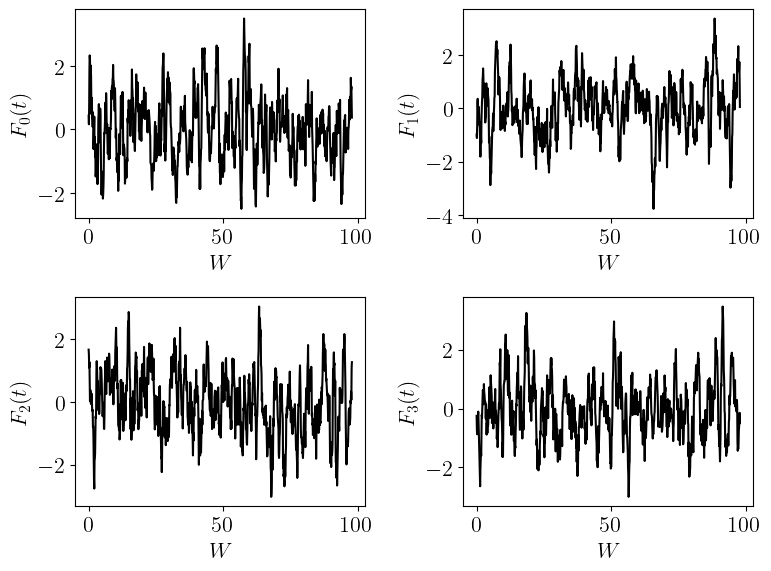

In [19]:
fig, axs = plt.subplots(int(len(lends)/2), int(len(lends)/2), figsize=(8, 6)) 
ax_flat = axs.ravel()
taxis = np.arange(multiscale_sep.shape[1])/cut_scl_fac
for jj in range(len(ax_flat)):
    ax_flat[jj].plot(taxis, multiscale_sep[jj, :],color='k')
    ax_flat[jj].set_ylabel(r"$F_{" + str(jj) + "}(t)$")
    ax_flat[jj].set_xlabel(r"$W$")
plt.tight_layout()
plt.savefig(f"Fluctuations.pdf", dpi=150, bbox_inches='tight') 

In [20]:
alpha_m = .05
kneighbor = 3
print(multiscale_sep.shape)

(4, 980)


In [21]:
info_content = information_comp(multiscale_sep, 10*cut_scl_fac, kneighbor)

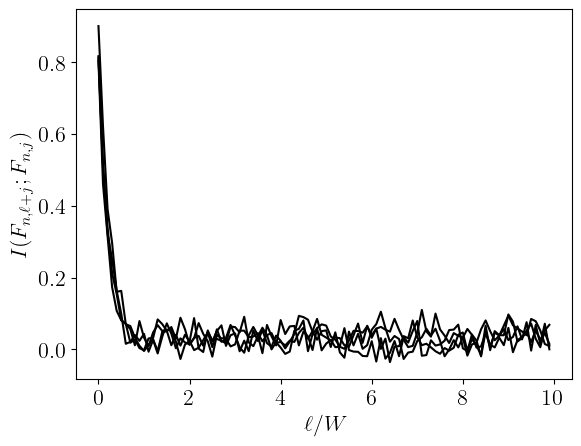

In [23]:
taxis_info = np.arange(info_content.shape[1])/cut_scl_fac
for jj in range(multiscale_sep.shape[0]):
    plt.plot(np.arange(info_content.shape[1])/cut_scl_fac, info_content[jj,:],c='k')
plt.xlabel(r"$\ell/W$")
plt.ylabel(r"$I(F_{n,\ell+j};F_{n,j})$")
plt.savefig(f"MMT_Info_in_Scale.pdf", dpi=150, bbox_inches='tight')

In [27]:
def results_and_averages(max_lag, ntrials):
    # WWT time regime, fast averaging
    all_results = [None]*ntrials
    for jj in range(ntrials):
        results_short = my_ceb.Model_Graph(data=multiscale_sep, max_lag=max_lag, 
                                    kneighbor=kneighbor, alpha_m=alpha_m)
        results_short.et_graph_model_builder()
        all_results[jj] = results_short
    pickle.dump(all_results, open("results_max_lag_"+str(max_lag)+".pkl", "wb"))
    return all_results


In [28]:
def statistics_maker(all_results, ntrials):
    avg_source_info_mat = np.zeros((len(lends),len(lends)),dtype=np.float64)
    avg_te_mat = np.zeros((len(lends),len(lends)),dtype=np.float64)
    avg_it_mat = np.zeros((len(lends),len(lends)),dtype=np.float64)
    var_source_info_mat = np.zeros((len(lends),len(lends)),dtype=np.float64)
    var_te_mat = np.zeros((len(lends),len(lends)),dtype=np.float64)
    var_it_mat = np.zeros((len(lends),len(lends)),dtype=np.float64)

    for jj in range(ntrials):
        avg_source_info_mat += all_results[jj].source_info_mat
        avg_te_mat += all_results[jj].te_mat
        avg_it_mat += all_results[jj].it_mat

    avg_source_info_mat /= ntrials
    avg_te_mat /= ntrials
    avg_it_mat /= ntrials

    for jj in range(ntrials):
        var_source_info_mat += (all_results[jj].source_info_mat - avg_source_info_mat)**2.
        var_te_mat += (all_results[jj].te_mat - avg_te_mat)**2.
        var_it_mat += (all_results[jj].it_mat - avg_it_mat)**2.

    var_source_info_mat /= ntrials
    var_te_mat /= ntrials
    var_it_mat /= ntrials
    return avg_source_info_mat, avg_it_mat, avg_te_mat, var_source_info_mat, var_te_mat, var_it_mat

In [29]:
ntrials = 100
max_lag = 2

In [30]:

current_results = results_and_averages(max_lag=2, ntrials=ntrials)
avg_source_info_mat, avg_it_mat, avg_te_mat, var_source_info_mat, var_te_mat, var_it_mat = statistics_maker(current_results, ntrials=ntrials)

No Selected Sources
For target 0
Target model: [1]
Chosen sources: []
Final information content of model: 0.0

No Selected Sources
For target 1
Target model: [1]
Chosen sources: []
Final information content of model: 0.0

No Selected Sources
For target 2
Target model: [1]
Chosen sources: []
Final information content of model: 0.0

No Selected Sources
For target 3
Target model: [1]
Chosen sources: []
Final information content of model: 0.0

No Selected Sources
For target 0
Target model: [1]
Chosen sources: []
Final information content of model: 0.0

No Selected Sources
For target 1
Target model: [1]
Chosen sources: []
Final information content of model: 0.0

No Selected Sources
For target 2
Target model: [1]
Chosen sources: []
Final information content of model: 0.0

No Selected Sources
For target 3
Target model: [1]
Chosen sources: []
Final information content of model: 0.0

No Selected Sources
For target 0
Target model: [1]
Chosen sources: []
Final information content of model: 0.0

N

In [600]:
long_lag_results = pickle.load(open("results_max_lag_20.pkl", "rb"))
max_lag = 2*cut_scl_fac

In [601]:
avg_source_info_mat, avg_it_mat, avg_te_mat, var_source_info_mat, var_te_mat, var_it_mat = statistics_maker(long_lag_results, ntrials=ntrials)

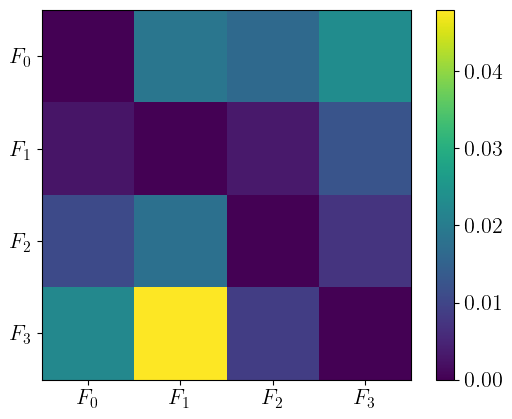

In [609]:
current_results[0].mat_visualizer(10**avg_source_info_mat, 'F', True, 'viridis')
plt.savefig("MMT_source_info_pval_"+str(alpha_m)+"_max_lag_"+str(max_lag) + ".pdf", dpi=150, bbox_inches='tight')  

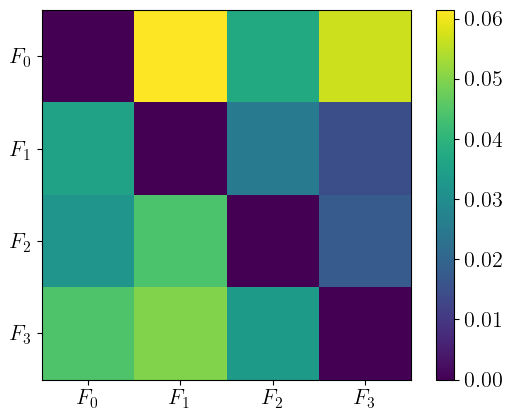

In [610]:
current_results[0].mat_visualizer(10**avg_te_mat, 'F', True, 'viridis')
plt.savefig("MMT_te_pval_" + str(alpha_m) + "_max_lag_" + str(max_lag) + ".pdf", dpi=150, bbox_inches='tight')  

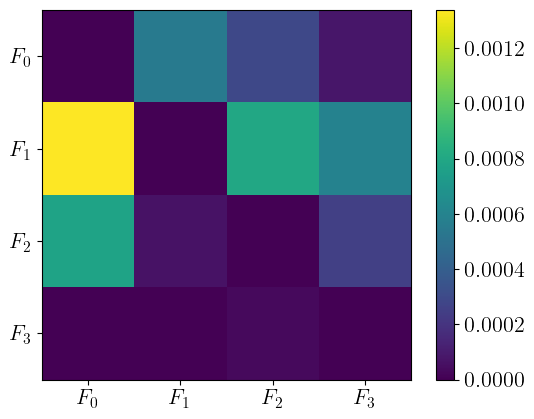

In [611]:
current_results[0].mat_visualizer(10**(var_te_mat), 'F', True, 'viridis')
plt.savefig("MMT_var_te_pval_" + str(alpha_m) + "_max_lag_" + str(max_lag) + ".pdf", dpi=150, bbox_inches='tight')  

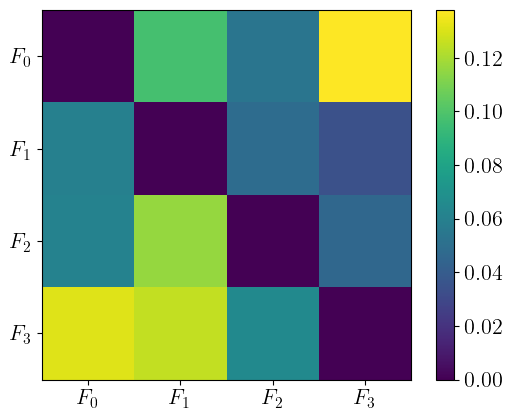

In [612]:
current_results[0].mat_visualizer(10**avg_it_mat, 'F', True, 'viridis')
plt.savefig("MMT_it_pval_"+str(alpha_m)+"_max_lag_"+str(max_lag) + ".pdf", dpi=150, bbox_inches='tight')  

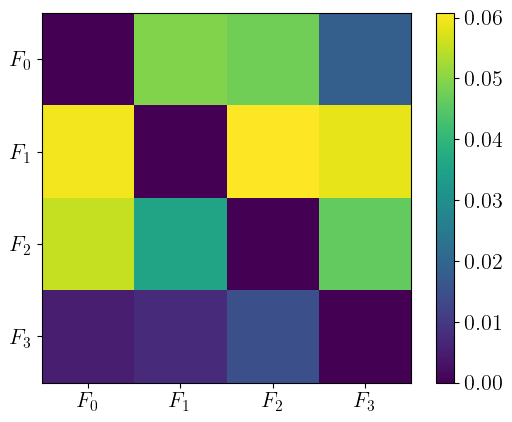

In [613]:
current_results[0].mat_visualizer(10**np.sqrt(var_it_mat), 'F', True, 'viridis')
plt.savefig("MMT_var_it_pval_" + str(alpha_m) + "_max_lag_" + str(max_lag) + ".pdf", dpi=150, bbox_inches='tight')  

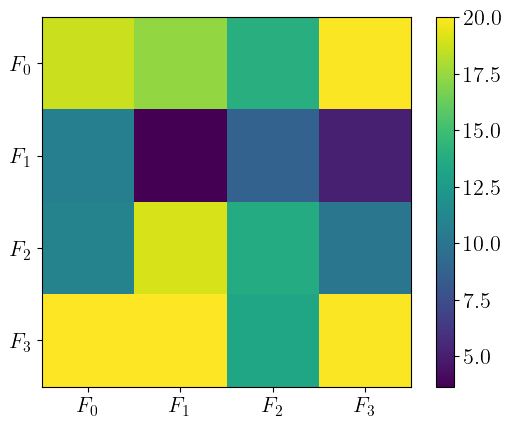

In [ ]:
lag_matrix_short = np.zeros((ntrials, 4, 4), dtype=int)
for jj in range(ntrials):
    for cnt, target in enumerate(current_results[jj].target_models):
        lag_matrix_short[jj, cnt, cnt] = max(target.model)

    all_original_indices = current_results[jj].chosen_sources_original_indices
    all_original_target_indices = current_results[jj].chosen_sources_for_target
        
    for cnt, best_e_graph in enumerate(current_results[jj].source_models):
        my_original_source_indices = all_original_indices[cnt]
        my_original_target_index = all_original_target_indices[cnt]        
        for next_cnt, source_label in enumerate(best_e_graph.chosen_sources):
            #original_index = my_original_indices[source_label]
            lag_matrix_short[jj, my_original_target_index, my_original_source_indices[next_cnt]] = max(best_e_graph.sources[source_label].model)

current_results[0].mat_visualizer(np.mean(lag_matrix_short,axis=0), 'F', False, 'viridis')
plt.savefig("MMT_lags_pval_" + str(alpha_m) + "_max_lag_" + str(max_lag) + ".pdf", dpi=150, bbox_inches='tight')  

In [608]:
short_lag_results = pickle.load(open("results_short_max_lag_10.pkl", "rb"))

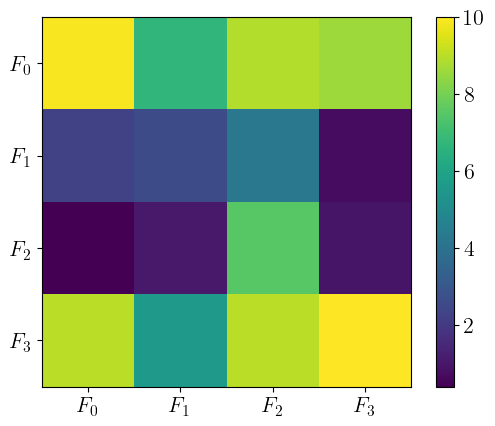

In [572]:
max_lag = cut_scl_fac
lag_matrix_short = np.zeros((ntrials, 4, 4), dtype=int)
for jj in range(ntrials):
    for cnt, target in enumerate(short_lag_results[jj].target_models):
        lag_matrix_short[jj, cnt, cnt] = max(target.model)

    all_original_indices = short_lag_results[jj].chosen_sources_original_indices
    all_original_target_indices = short_lag_results[jj].chosen_sources_for_target
        
    for cnt, best_e_graph in enumerate(short_lag_results[jj].source_models):
        my_original_source_indices = all_original_indices[cnt]
        my_original_target_index = all_original_target_indices[cnt]        
        for next_cnt, source_label in enumerate(best_e_graph.chosen_sources):
            #original_index = my_original_indices[source_label]
            lag_matrix_short[jj, my_original_target_index, my_original_source_indices[next_cnt]] = max(best_e_graph.sources[source_label].model)

short_lag_results[0].mat_visualizer(np.mean(lag_matrix_short,axis=0), 'F', False, 'viridis')
plt.savefig("MMT_short_lags_pval_" + str(alpha_m) + "_max_lag_" + str(max_lag) + ".pdf", dpi=150, bbox_inches='tight')  


In [579]:
max_lag = cut_scl_fac
avg_source_info_mat, avg_it_mat, avg_te_mat, var_source_info_mat, var_te_mat, var_it_mat = statistics_maker(short_lag_results, ntrials=ntrials)

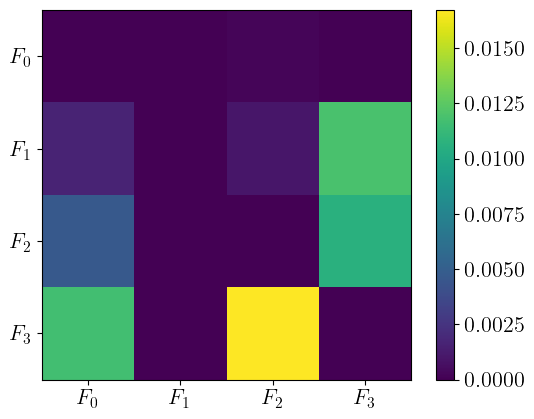

In [587]:
current_results[0].mat_visualizer(10**(avg_source_info_mat), 'F', True, 'viridis')
plt.savefig("MMT_source_info_pval_" + str(alpha_m) + "_max_lag_" + str(max_lag) + ".pdf", dpi=150, bbox_inches='tight')  

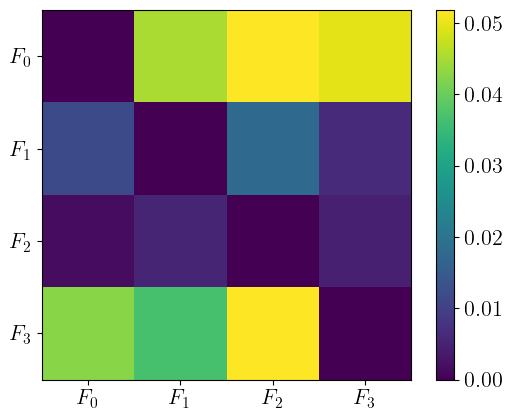

In [585]:
current_results[0].mat_visualizer(10**(avg_te_mat), 'F', True, 'viridis')
plt.savefig("MMT_te_pval_" + str(alpha_m) + "_max_lag_" + str(max_lag) + ".pdf", dpi=150, bbox_inches='tight')  

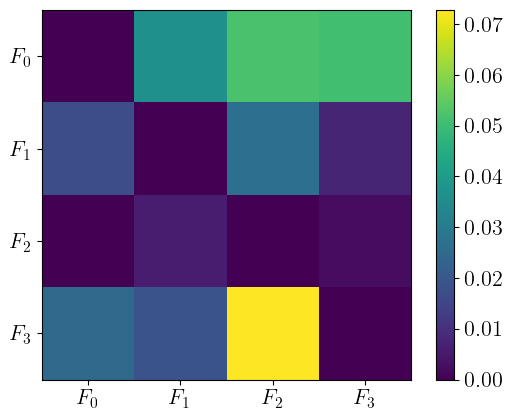

In [586]:
current_results[0].mat_visualizer(10**(avg_it_mat), 'F', True, 'viridis')
plt.savefig("MMT_it_pval_" + str(alpha_m) + "_max_lag_" + str(max_lag) + ".pdf", dpi=150, bbox_inches='tight')  

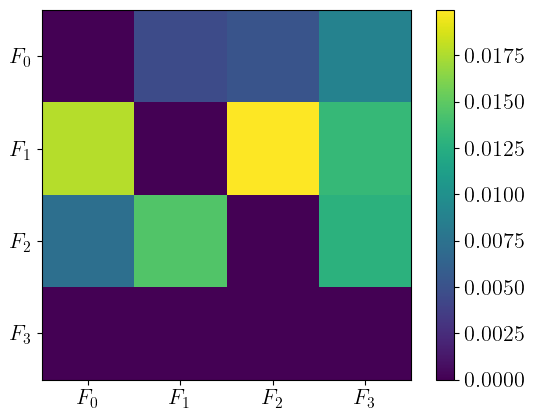

In [588]:
current_results[0].mat_visualizer(10**(np.sqrt(var_te_mat)), 'F', True, 'viridis')
plt.savefig("MMT_var_te_pval_" + str(alpha_m) + "_max_lag_" + str(max_lag) + ".pdf", dpi=150, bbox_inches='tight')  

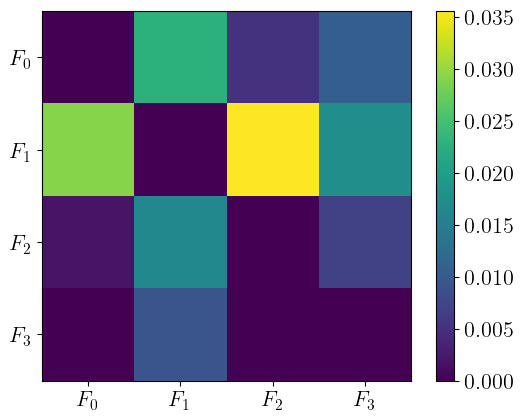

In [589]:
current_results[0].mat_visualizer(10**(np.sqrt(var_it_mat)), 'F', True, 'viridis')
plt.savefig("MMT_var_it_pval_" + str(alpha_m) + "_max_lag_" + str(max_lag) + ".pdf", dpi=150, bbox_inches='tight')  